#IMPORT LIBRARIES

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

#LOAD DATASET & BASIC PREPROCESSING

In [3]:
df=pd.read_csv("P614 DATASET.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2012,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,04-01-2012,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,05-01-2012,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,06-01-2012,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,09-01-2012,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [5]:
print("Shape of dataset:", df.shape)

Shape of dataset: (2011, 7)


In [6]:
print("\nColumn Names:", df.columns)


Column Names: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [7]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Open       2011 non-null   float64
 2   High       2011 non-null   float64
 3   Low        2011 non-null   float64
 4   Close      2011 non-null   float64
 5   Adj Close  2011 non-null   float64
 6   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 110.1+ KB
None


In [8]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
              Open         High          Low        Close    Adj Close  \
count  2011.000000  2011.000000  2011.000000  2011.000000  2011.000000   
mean    126.707469   127.827594   125.580258   126.741235   119.505548   
std      50.483753    50.926301    50.124940    50.578369    52.438444   
min      55.424286    57.085712    55.014286    55.790001    48.921928   
25%      85.882858    86.717858    85.056427    86.202145    75.056679   
50%     113.050003   114.190002   111.870003   113.050003   105.222908   
75%     165.190002   167.409996   163.424995   165.245002   160.047111   
max     291.119995   293.970001   288.119995   291.519989   289.522614   

             Volume  
count  2.011000e+03  
mean   5.949670e+07  
std    4.683856e+07  
min    1.136200e+07  
25%    2.758565e+07  
50%    4.346900e+07  
75%    7.471030e+07  
max    3.765300e+08  


In [9]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [10]:
print("Duplicate Values:")
print(df.duplicated().sum())

Duplicate Values:
0


In [11]:
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

#CLOSE PRICE TREND

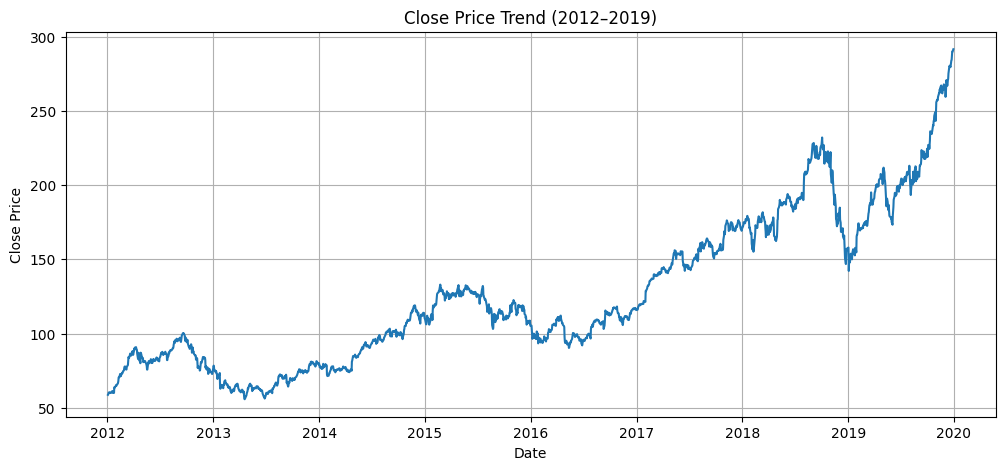

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'])
plt.title("Close Price Trend (2012–2019)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

#Volume Trend

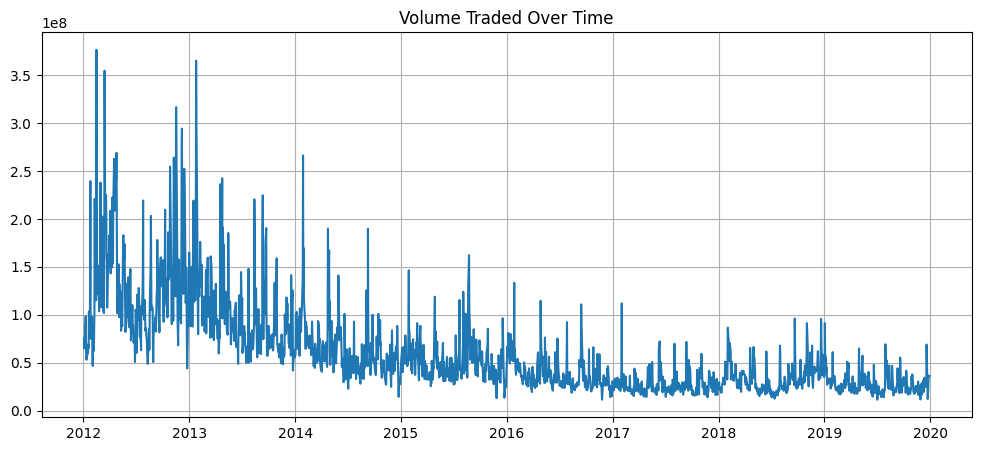

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Volume'])
plt.title("Volume Traded Over Time")
plt.grid(True)
plt.show()

#Daily Returns

In [14]:
df['Daily_Return'] = df['Close'].pct_change()

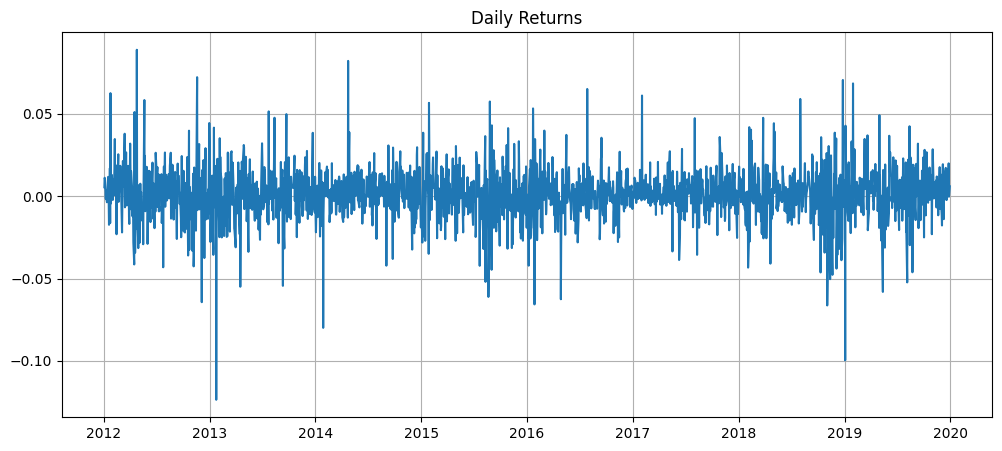

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Daily_Return'])
plt.title("Daily Returns")
plt.grid(True)
plt.show()

#Correlation Heatmap

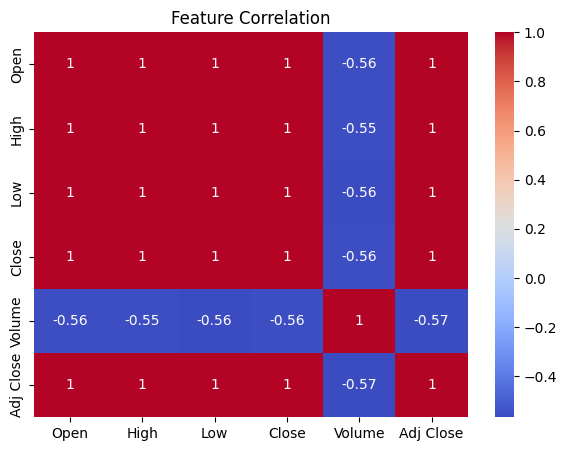

In [16]:
plt.figure(figsize=(7,5))
sns.heatmap(df[['Open','High','Low','Close','Volume','Adj Close']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

#TIME-SERIES ANALYSIS (ACF & PACF)

In [100]:
# Differencing to make the series stationary
close_diff = df["Close"].diff().dropna()

<Figure size 1200x400 with 0 Axes>

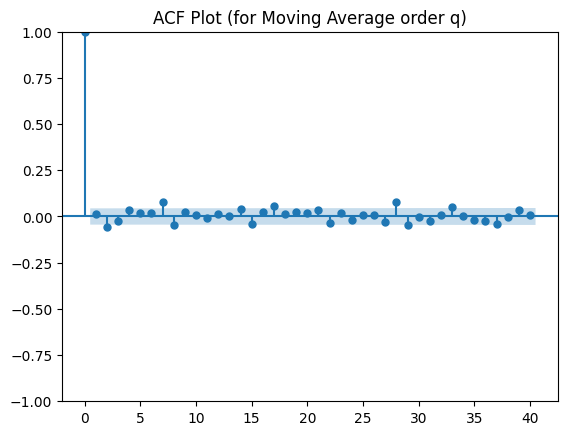

In [109]:
#ACF Plot – helps identify q parameter
plt.figure(figsize=(12,4))
plot_acf(close_diff, lags=40)
plt.title("ACF Plot (for Moving Average order q)")
plt.show()

<Figure size 1200x400 with 0 Axes>

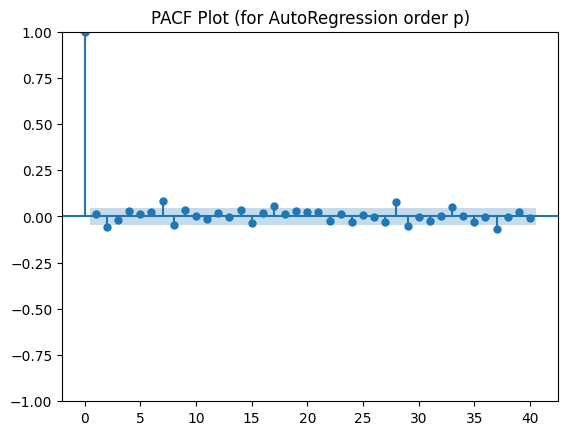

In [110]:
#PACF Plot – helps identify p parameter
plt.figure(figsize=(12,4))
plot_pacf(close_diff, lags=40, method="ywm")
plt.title("PACF Plot (for AutoRegression order p)")
plt.show()

#FEATURE ENGINEERING

In [17]:
# Lag Features
for lag in range(1, 8):
    df[f"lag_close_{lag}"] = df["Close"].shift(lag)


In [18]:
# Moving Averages
df["MA7"] = df["Close"].rolling(7).mean()
df["MA30"] = df["Close"].rolling(30).mean()

In [19]:
# Volatility
df["Volatility_7"] = df["Close"].rolling(7).std()
df["Volatility_30"] = df["Close"].rolling(30).std()

In [20]:
# Returns
df["Return_7"] = df["Close"].pct_change(7)
df["Return_30"] = df["Close"].pct_change(30)

In [21]:
# Date Features
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['weekday'] = df['Date'].dt.dayofweek

In [22]:
# Drop rows with NaN from shifting
df.dropna(inplace=True)

In [23]:
df = df.reset_index(drop=True)

In [24]:
df.shape

(1981, 25)

In [25]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,lag_close_1,lag_close_2,...,MA7,MA30,Volatility_7,Volatility_30,Return_7,Return_30,day,month,year,weekday
0,2012-02-15,73.465714,75.184288,70.984283,71.095711,61.436600,376530000,-0.023142,72.779999,71.800003,...,70.241429,63.986286,2.040094,4.166554,0.072634,0.210199,15,2,2012,2
1,2012-02-16,70.214287,72.127144,69.518570,71.744286,61.997032,236138000,0.009123,71.095711,72.779999,...,70.922653,64.409000,1.489806,4.291253,0.071198,0.214711,16,2,2012,3
2,2012-02-17,71.872856,72.538574,71.471428,71.731430,61.985954,133951300,-0.000179,71.744286,71.095711,...,71.441837,64.809428,0.826730,4.397642,0.053369,0.201158,17,2,2012,4
3,2012-02-21,72.411430,73.550003,72.017143,73.550003,63.557446,151398800,0.025353,71.731430,71.744286,...,71.884286,65.249667,1.016272,4.591865,0.043961,0.218868,21,2,2012,1
4,2012-02-22,73.297142,73.641426,72.724289,73.291428,63.334015,120825600,-0.003516,73.550003,71.731430,...,72.284694,65.684476,0.922550,4.717701,0.039763,0.216513,22,2,2012,2


#STATISTICAL TIME-SERIES MODELS

In [93]:
# Train-Test Split for Time-Series Models
train_size = int(len(df) * 0.8)
train_ts = df["Close"][:train_size]
test_ts = df["Close"][train_size:]


In [97]:
#ARIMA MODEL
arima_model = ARIMA(train_ts, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(len(test_ts))
arima_mae = mean_absolute_error(test_ts, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test_ts, arima_pred))


In [98]:
print("\n ARIMA")
print("MAE :", arima_mae)
print("RMSE:", arima_rmse)


 ARIMA
MAE : 24.97023481407064
RMSE: 33.40097318300098


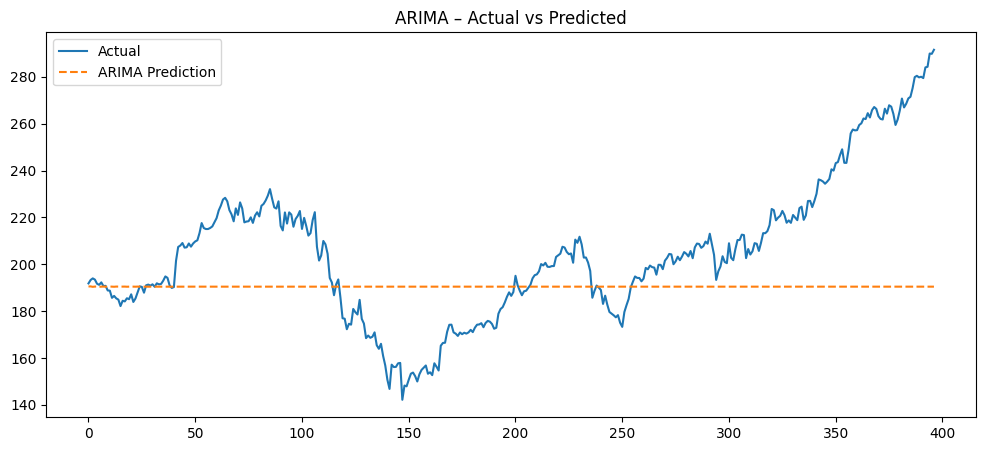

In [72]:
plt.figure(figsize=(12,5))
plt.plot(test_ts.values, label="Actual")
plt.plot(arima_pred.values, label="ARIMA Prediction", linestyle="--")
plt.title("ARIMA – Actual vs Predicted")
plt.legend()
plt.show()

In [73]:
#SARIMA MODEL
sarima_model = SARIMAX(
    train_ts,
    order=(2,1,2),
    seasonal_order=(1,1,1,12)
)
sarima_fit = sarima_model.fit()
sarima_pred = sarima_fit.forecast(len(test_ts))

sarima_mae = mean_absolute_error(test_ts, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(test_ts,sarima_pred))


In [74]:
print("\n SARIMA")
print("MAE :", sarima_mae)
print("RMSE:", sarima_rmse)



 SARIMA
MAE : 21.159770043837728
RMSE: 26.726028267541945


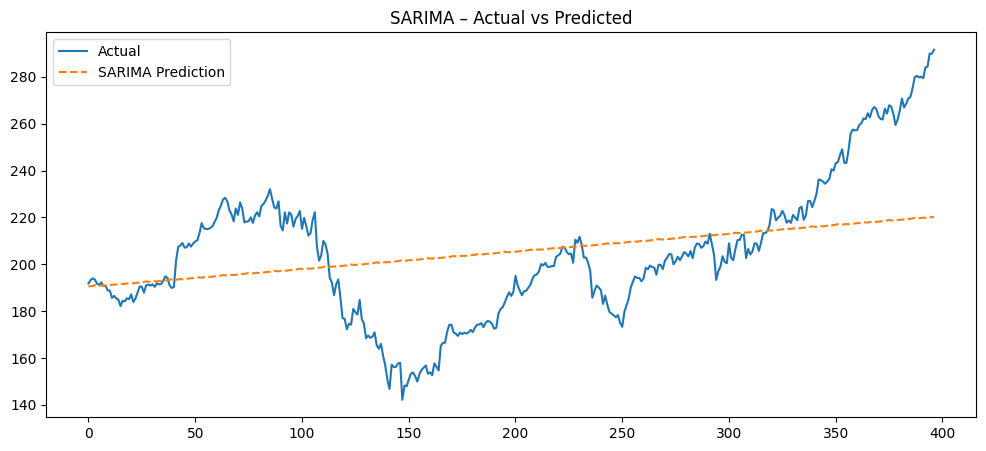

In [75]:
plt.figure(figsize=(12,5))
plt.plot(test_ts.values, label="Actual")
plt.plot(sarima_pred.values, label="SARIMA Prediction", linestyle="--")
plt.title("SARIMA – Actual vs Predicted")
plt.legend()
plt.show()

#MACHINE LEARNING MODELS

In [76]:
feature_columns = [
    'Open','High','Low','Volume','Adj Close',
    'lag_close_1','lag_close_2','lag_close_3','lag_close_4',
    'lag_close_5','lag_close_6','lag_close_7',
    'MA7','MA30','Volatility_7','Volatility_30',
    'Daily_Return','Return_7','Return_30',
    'day','month','year','weekday'
]

In [77]:
X = df[feature_columns]
y = df["Close"]

In [94]:
# Train-Test Split (No Shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [95]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# RANDOM FOREST

In [79]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

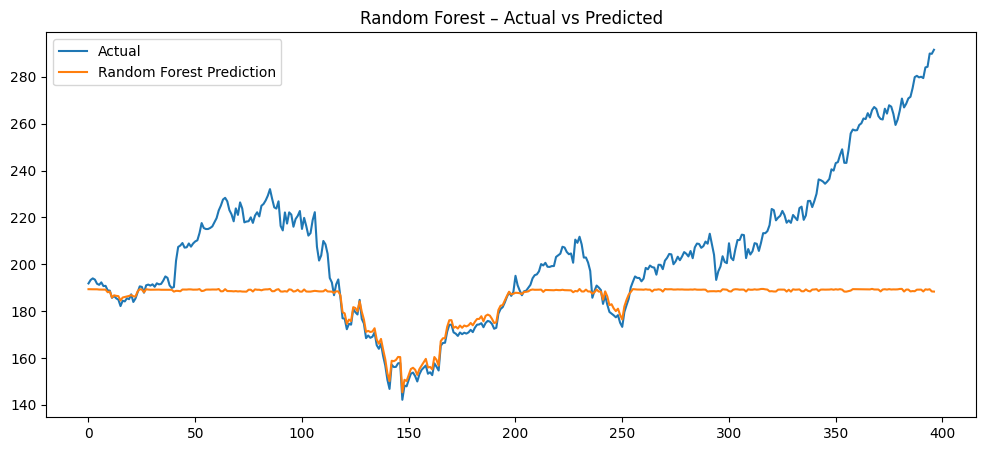

In [80]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual")
plt.plot(rf_pred, label="Random Forest Prediction")
plt.title("Random Forest – Actual vs Predicted")
plt.legend()
plt.show()

In [82]:
'''rf_param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}
grid_search=GridSearchCV(rf,rf_param_grid)
grid_search.fit(X_train_scaled,y_train)
print("Best Parameters:", grid_search.best_params_)'''

'rf_param_grid = {\n    "n_estimators": [200, 300],\n    "max_depth": [None, 10],\n    "min_samples_split": [2, 5]\n}\ngrid_search=GridSearchCV(rf,rf_param_grid)\ngrid_search.fit(X_train_scaled,y_train)\nprint("Best Parameters:", grid_search.best_params_)'

In [83]:
print("\n RANDOM FOREST")
print("MAE :", mean_absolute_error(y_test, rf_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))


 RANDOM FOREST
MAE : 21.271563718564337
RMSE: 32.16522764024826


#XGBOOST

In [84]:

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

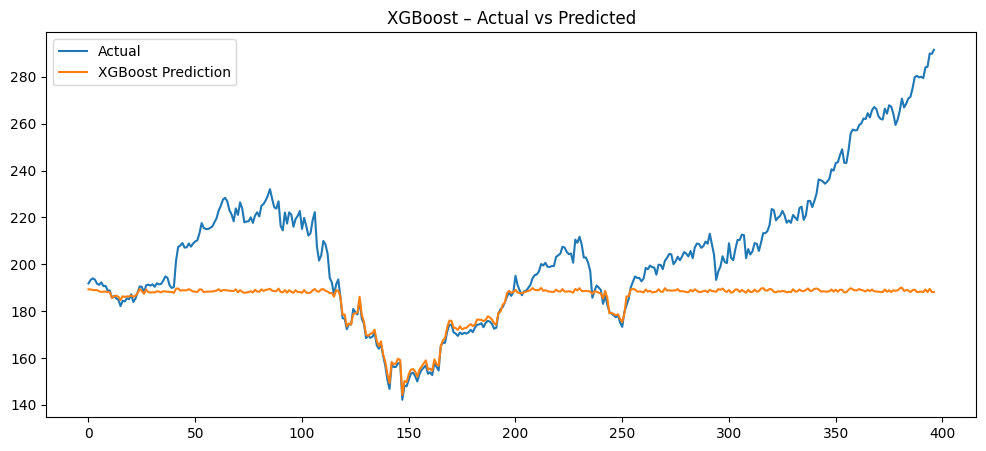

In [85]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual")
plt.plot(xgb_pred, label="XGBoost Prediction")
plt.title("XGBoost – Actual vs Predicted")
plt.legend()
plt.show()

In [86]:
xgb_param_grid = {
    "n_estimators": [300, 500],
    "learning_rate": [0.05, 0.1],
    "max_depth": [4, 6],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}
grid_search=GridSearchCV(xgb,xgb_param_grid)
grid_search.fit(X_train_scaled,y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}


In [87]:
print("\n XGBOOST")
print("MAE :", mean_absolute_error(y_test, xgb_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))


 XGBOOST
MAE : 21.30666145769541
RMSE: 32.3356304086686


In [89]:
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

# MODEL COMPARISON & EVALUATION

In [96]:
comparison = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Random Forest", "XGBoost"],
    "MAE": [arima_mae, sarima_mae, rf_mae, xgb_mae],
    "RMSE": [arima_rmse, sarima_rmse, rf_rmse, xgb_rmse]
})

print("\n FINAL MODEL COMPARISON")
print(comparison)


 FINAL MODEL COMPARISON
           Model        MAE       RMSE
0          ARIMA  24.938995  33.365259
1         SARIMA  21.159770  26.726028
2  Random Forest  21.271564  32.165228
3        XGBoost  21.306661  32.335630


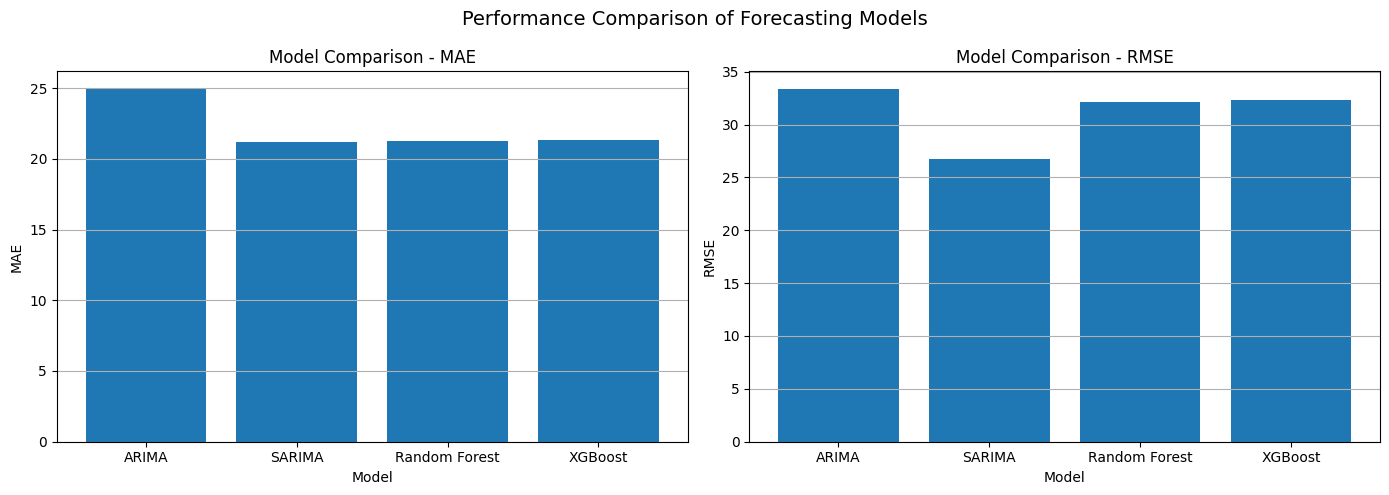

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# ---- MAE Plot ----
axes[0].bar(comparison["Model"], comparison["MAE"])
axes[0].set_title("Model Comparison - MAE")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("MAE")
axes[0].grid(axis="y")

# ---- RMSE Plot ----
axes[1].bar(comparison["Model"], comparison["RMSE"])
axes[1].set_title("Model Comparison - RMSE")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("RMSE")
axes[1].grid(axis="y")

plt.suptitle("Performance Comparison of Forecasting Models", fontsize=14)
plt.tight_layout()
plt.show()